In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from glob import glob
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

random.seed(42)

In [2]:
train_input_path = '../cityscapes_data/cityscapes_data/train'
val_input_path = '../cityscapes_data/cityscapes_data/val'
train_output_path = '../02_processed/train'
val_output_path = '../02_processed/val'

os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

In [3]:
train_samples = 30
num_classes = 12

In [4]:
train_image_paths = glob(os.path.join(train_input_path, '*.jpg'))
val_image_paths = glob(os.path.join(val_input_path, '*.jpg'))

train_kmeans_sample = random.sample(train_image_paths, k=train_samples)

In [5]:
def train_knn(image_paths, num_classes: int = 12):
    images = list(map(lambda p: cv2.imread(p)[:, 256:], image_paths))
    images = list(map(lambda img: img.reshape((-1, 3)), images))
    images = np.array(images).reshape(-1, 3)
    kmeans_models = KMeans(n_clusters=num_classes)
    kmeans_models.fit(images)
    return kmeans_models

In [6]:
kmeans_model = train_knn(train_kmeans_sample, num_classes)

In [7]:
def process_images(input_path, model: KMeans):
    images = []
    masks = []
    num_classes = len(model.cluster_centers_)
    for path in tqdm(input_path):
        image_mask = cv2.imread(path)
        image = image_mask[:, :256]
        image=cv2.normalize(image,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        mask = image_mask[:, 256:]
        labels = model.predict(mask.reshape(-1, 3))
        mask = labels.reshape(mask.shape[0], mask.shape[1])
        one_hot_encoded_mask= np.zeros((num_classes, *mask.shape), dtype=int)
        for i in range(num_classes):
            one_hot_encoded_mask[i][mask == i] = 1
        images.append(image)
        masks.append(one_hot_encoded_mask)
    return images, masks
        

images, masks = process_images(train_image_paths, kmeans_model)
val_images, val_masks = process_images(val_image_paths, kmeans_model)

100%|██████████| 500/500 [00:01<00:00, 254.88it/s]


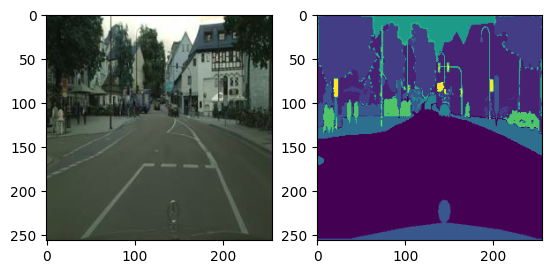

In [8]:
img_id = np.random.randint(0, len(train_image_paths))
image_processed, mask_processed = images[img_id], masks[img_id]
plt.subplot(1, 2, 1)
plt.imshow(image_processed)
plt.subplot(1, 2, 2)
plt.imshow(np.argmax(mask_processed, axis=0))
plt.show()

In [9]:
for image_id, (image, mask) in tqdm(enumerate(zip(images, masks)), total=max(len(images), len(masks))):
    np.save(os.path.join(train_output_path, f"image_{image_id}.npy"), np.transpose(image, (2, 0, 1)))
    np.save(os.path.join(train_output_path, f"mask_{image_id}.npy"), mask)

100%|██████████| 2975/2975 [00:22<00:00, 130.73it/s]


In [10]:
for image_id, (image, mask) in tqdm(enumerate(zip(val_images, val_masks)), total=max(len(val_images), len(val_masks))):
    np.save(os.path.join(val_output_path, f"image_{image_id}.npy"), np.transpose(image, (2, 0, 1)))
    np.save(os.path.join(val_output_path, f"mask_{image_id}.npy"), mask)

100%|██████████| 500/500 [00:04<00:00, 118.42it/s]
